# Colombia Gridded Fire Danger Exploration
## Step 1: Explore gridded maximum temperature
### 27 Sept 2022, W. Matt Jolly, USFS, RMRS, Missoula Fire Sciences Laboratory

In [1]:
%matplotlib inline
import sys,os,locale,requests
import xarray as xr
import rioxarray
import numpy as np
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from datetime import *
from dask.diagnostics import ProgressBar
from dask.distributed import progress, Client, LocalCluster
import contextily as cx

#from NFDRS import *
locale.setlocale(locale.LC_TIME, 'es_ES.UTF-8')

'es_ES.UTF-8'

In [2]:
# Use thie client connection to connect to an existing cluster
#client = Client('tcp://127.0.0.1:40539')
# Uncomment out the next 2 lines to create a local cluster for Dask
cluster = LocalCluster(dashboard_address=':8788')
client = Client(cluster)
print(client)
client

2022-09-27 14:51:49,565 - distributed.diskutils - INFO - Found stale lock file and directory '/mnt/nvmSSD/data/sar/co/SAR-Colombia/dask-worker-space/worker-d253r08t', purging
2022-09-27 14:51:49,565 - distributed.diskutils - INFO - Found stale lock file and directory '/mnt/nvmSSD/data/sar/co/SAR-Colombia/dask-worker-space/worker-dlidp9fu', purging
2022-09-27 14:51:49,565 - distributed.diskutils - INFO - Found stale lock file and directory '/mnt/nvmSSD/data/sar/co/SAR-Colombia/dask-worker-space/worker-xtq3npq8', purging
2022-09-27 14:51:49,565 - distributed.diskutils - INFO - Found stale lock file and directory '/mnt/nvmSSD/data/sar/co/SAR-Colombia/dask-worker-space/worker-uyc2ck38', purging
2022-09-27 14:51:49,566 - distributed.diskutils - INFO - Found stale lock file and directory '/mnt/nvmSSD/data/sar/co/SAR-Colombia/dask-worker-space/worker-h7mqpq8x', purging
2022-09-27 14:51:49,566 - distributed.diskutils - INFO - Found stale lock file and directory '/mnt/nvmSSD/data/sar/co/SAR-Col

<Client: 'tcp://127.0.0.1:57677' processes=8 threads=48, memory=251.80 GiB>


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8788/status,
Dashboard: http://127.0.0.1:8788/status,Workers: 8
Total threads: 48,Total memory: 251.80 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:57677,Workers: 8
Dashboard: http://127.0.0.1:8788/status,Total threads: 48
Started: Just now,Total memory: 251.80 GiB
Comm: tcp://127.0.0.1:41066,Total threads: 6
Dashboard: http://127.0.0.1:36835/status,Memory: 31.47 GiB
Nanny: tcp://127.0.0.1:33291,


In [3]:
# Load the country boundaries file
countries_path = "zip://./Data/ne_10m_admin_0_countries_lakes.zip"
states_path = "zip://.//Data/ne_10m_admin_1_states_provinces_lakes.zip"

# Load the state boundaries file and filter for CONUS
states_gdf = gpd.read_file(states_path)
countries_gdf = gpd.read_file(countries_path)
#SARBnd = states_gdf[states_gdf['iso_a2'].isin(['PE','CO','EC','BO','CL','AR','BR','UR','VE','UY','PY','GY','SR','GF'])]
COBnd = states_gdf[states_gdf['iso_a2'].isin(['CO'])]

In [4]:
COCountryBnd = COBnd.dissolve(by='iso_a2')

In [22]:
#python program to check if a directory exists
path = "Figures"
# Check whether the specified path exists or not
isExist = os.path.exists(path)
if not isExist:
   # Create a new directory because it does not exist
   os.makedirs(path)
   print(f"The new directory {path} is created!")

The new directory Figures is created!


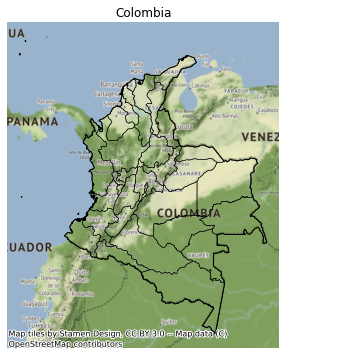

In [23]:
f, ax = plt.subplots(figsize=(11, 6))
COBnd.plot(color='None',edgecolor='black',linewidth=0.5,ax=ax,zorder=4)
COCountryBnd.plot(color='None',edgecolor='black',linewidth=1,ax=ax,zorder=3)
ax.set(title=f"Colombia")
ax.axis('off')
plt.grid()
cx.add_basemap(ax, crs=COBnd.crs)
#plt.show()
fout = f'./Figures/co_bound.png'
plt.savefig(fout, dpi=500, bbox_inches='tight')

In [24]:
# Note: This function was found and reused to help with the Error 406 I was getting from the Natural Earth download
# It requires the request to send a header first so the server can interpret the request
def download_file(url,local_filename):
    #local_filename = url.split('/')[-1]
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
    # NOTE the stream=True parameter below
    with requests.get(url, headers=headers,stream=True) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                # If you have chunk encoded response uncomment if
                # and set chunk_size parameter to None.
                #if chunk: 
                f.write(chunk)
    return local_filename



In [25]:
#python program to check if a directory exists
path = "Data"
# Check whether the specified path exists or not
isExist = os.path.exists(path)
if not isExist:
   # Create a new directory because it does not exist
   os.makedirs(path)
   print(f"The new directory {path} is created!")

In [26]:
# Download the Natural Earth admin files for levels 0 and 1
fname = 'era5-land-CO-tmax-2000-2020.nc'
url = f'http://www.wfas.net/data/sar/netcdf/{fname}'
tmaxfile = f'./Data/{fname}'
if not os.path.exists(tmaxfile):
    download_file(url,tmaxfile)

In [27]:
fname = 'era5-land-CO-tmin-2000-2020.nc'
url = f'http://www.wfas.net/data/sar/netcdf/{fname}'
tminfile = f'./Data/{fname}'
if not os.path.exists(tminfile):
    download_file(url,tminfile)

In [10]:
mychunk = {'latitude':25,'longitude':25,'time': -1}

In [11]:
zone_tmax = xr.open_mfdataset(tmaxfile,chunks=mychunk,parallel=True,engine='netcdf4')
zone_tmin = xr.open_mfdataset(tminfile,chunks=mychunk,parallel=True,engine='netcdf4')
zone_tmax['jday'] = zone_tmax.time.dt.dayofyear
zone_tmax['month'] = zone_tmax.time.dt.month
zone_tmax['year'] = zone_tmax.time.dt.year

In [12]:
print(zone_tmax.sizes)
print(zone_tmin.sizes)


Frozen({'latitude': 166, 'longitude': 121, 'time': 7671})
Frozen({'latitude': 166, 'longitude': 121, 'time': 7671})


In [14]:
# Villavicencio, Meta, Colombia
lat = 4.151382
lon = -73.637688

In [15]:
# Extract a point from the gridded dataset for maximum temperature

In [16]:
zone_tmax_pt = zone_tmax.sel(latitude=[lat],longitude=[lon],method='nearest')

In [17]:
zone_tmax_pt 

<xarray.Dataset>
Dimensions:      (latitude: 1, longitude: 1, time: 7671)
Coordinates:
  * latitude     (latitude) float32 4.2
  * longitude    (longitude) float32 -73.6
  * time         (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2020-12-31
Data variables:
    spatial_ref  int64 ...
    t2m          (time, latitude, longitude) float32 dask.array<chunksize=(7671, 1, 1), meta=np.ndarray>
    jday         (time) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
    month        (time) int64 1 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 12
    year         (time) int64 2000 2000 2000 2000 2000 ... 2020 2020 2020 2020

Text(0.5, 0, 'Time')

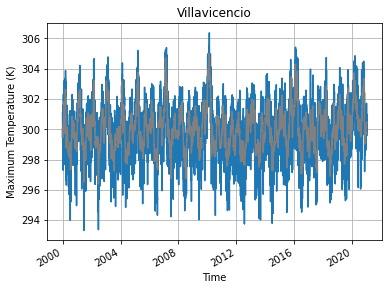

In [18]:
zone_tmax_pt.t2m.plot()
zone_tmax_pt.t2m.rolling(time=15 ,center=True).mean().plot(color='grey')
plt.grid()
plt.gca().set_ylabel("Maximum Temperature (K)")
plt.title("Villavicencio")
plt.gca().set_xlabel("Time")

In [19]:
zone_tmax_pt = zone_tmax.sel(latitude=[lat],longitude=[lon],method='nearest')

In [20]:
# Make a daily average temperature plot for Villavicencio

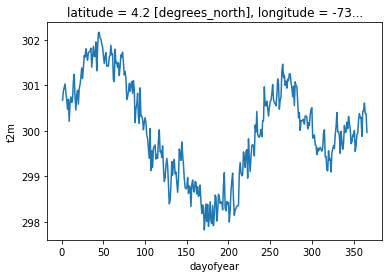

In [21]:
zone_tmax_pt.t2m.groupby(zone_tmax_pt.time.dt.dayofyear).mean().plot()